In [1]:
import sys
root = "/data/luojaa/eukgen/"
sys.path.append(root)

In [2]:
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [3]:
tree_data = pd.read_csv("/data/luojaa/eukgen/new_microcosm.merged_tree_data.tsv", sep = "\t").set_index("tree_name").dropna()
kegg_annot = pd.read_csv("/data/tobiassonva/data/eukgen/processing/euk72_ep/euk72_ep.KEGG_annotation.swapped_names.tsv", sep = "\t")
annotated_clusters = set(kegg_annot.Query)
tree_data_annot = tree_data[tree_data.index.isin(annotated_clusters)].reset_index()
tree_data_annot_tmp = tree_data_annot.set_index("tree_name")
kegg_annot_tmp = kegg_annot.set_index("Query")[["Target", "Score", "Description", "Pairwise_cov"]]
tree_data_mapped = pd.merge(tree_data_annot_tmp, kegg_annot_tmp, left_index= True, right_index= True, how= "left")#.drop("Unnamed: 0", axis = 1)
tree_data_tophits = tree_data_mapped.sort_values(["euk_clade_rep", "Score"], ascending = False).drop_duplicates(["euk_clade_rep", "prok_clade_rep"])

In [4]:
ec_koginfo = pd.read_csv("/data/luojaa/kegg_stats/KOG_merged.tsv", sep = "\t")
ec_koginfo["EC_single"] = ec_koginfo["EC"].apply(lambda x: x.split("|"))
ec_koginfo = ec_koginfo.explode("EC_single")
ec_2kog = ec_koginfo[ec_koginfo.EC_single != "none" ].loc[:,["kogid", "name", "EC_single"]]
ec_2kogs = ec_2kog.groupby("EC_single")["kogid"].apply(lambda x: "|".join(set(x))).reset_index().rename(columns={"EC_single":"EC","kogid":"KOGS"})

ec_2kog_dict = ec_2kog.drop("name", axis = 1).set_index("kogid").to_dict()["EC_single"]
ec_kogs = set(ec_2kog[~ec_2kog.EC_single.str.contains("-")].kogid)
tree_data_mapped_2ec = tree_data_tophits[tree_data_tophits.Target.isin(ec_kogs)].reset_index()
tree_data_mapped_2ec["EC"] = tree_data_mapped_2ec.Target.apply(lambda x: ec_2kog_dict[x])

In [5]:
tree_data_dl = pd.read_csv("/data/luojaa/eukgen/microcosm_dl_new_tree_data.tsv", sep = "\t").dropna()
tree_data_dl["EC"] = tree_data_dl.tree_name.apply(lambda x: x.split("_")[0])
dl_annot = pd.read_csv("/data/luojaa/eukgen/microcosm/repseq.microcosms.tmp.tsv", sep = "\t").drop("domain", axis = 1).rename(columns = {"Query":"euk_clade_rep"})

ec_descriptions = pd.read_csv("/data/luojaa/microcosm_metadata/brenda_ec_mappings.tsv", sep = "\t")
ec_info = pd.merge(ec_2kogs, ec_descriptions, on="EC", how="right").drop("comments", axis=1)
tree_data_dl_mapped = pd.merge(tree_data_dl, dl_annot, on=["euk_clade_rep", "EC"], how="left")
tree_data_dl_mapped = pd.merge(tree_data_dl_mapped, ec_info, on="EC", how="left")
tree_data_dl_mapped.fillna("None", inplace=True)
tree_data_dl_mapped = tree_data_dl_mapped.set_index("tree_name")

/tmp/ipykernel_3491552/89221551.py:1: DtypeWarning: Columns (3,4,7,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  tree_data_dl = pd.read_csv("/data/luojaa/eukgen/microcosm_dl_new_tree_data.tsv", sep = "\t").dropna()


In [6]:
trees_dl_cELW = tree_data_dl_mapped[tree_data_dl_mapped["c-ELW"].between(.5,1) & (tree_data_dl_mapped.logL != -1)].reset_index()#.drop("index")
trees_cELW = tree_data_mapped_2ec[tree_data_mapped_2ec["c-ELW"].between(.5,1) & (tree_data_mapped_2ec.logL != -1)].reset_index().drop("index", axis = 1)
trees_cELW["EC_KOG"] = trees_cELW.EC + "_" + trees_cELW.Target
ec2cELWsum = {}
for eckog in set(trees_cELW["EC_KOG"]):
    ec2cELWsum[eckog] = trees_cELW[trees_cELW.EC_KOG == eckog]["c-ELW"].sum()
trees_cELW["cELW_norm"] = trees_cELW["c-ELW"] / trees_cELW.EC_KOG.apply(lambda x: ec2cELWsum[x])

# trees_cELW.to_csv("/data/luojaa/eukgen/microcosm/trees_cELW_sankey.updated.tsv", sep = "\t", index = None)
# trees_dl_cELW.to_csv("/data/luojaa/eukgen/microcosm/trees_dl_cELW_sankey.updated.tsv", sep = "\t", index = None)

In [7]:
kog_brite = pd.read_csv("/data/luojaa/kegg_stats/KOG_merged.tsv", sep = "\t")
brite_desc = pd.read_csv("/data/tobiassonva/data/databases/kegg/kegg_metadata/KOG_brite_map.tsv", dtype=str, sep = "\t").set_index("brite_id")
brite_b_desc = brite_desc.drop(["brite_C", "level"], axis = 1).drop_duplicates(["brite_A","brite_B"])
brite_b_desc = brite_b_desc[brite_b_desc.brite_B != "none"]

In [8]:
kog_functions = pd.read_csv('/data/luojaa/uid_stats/kog_functions.tsv', sep = '\t').drop_duplicates("KOGID")
category_data = pd.read_csv('/data/luojaa/kegg_stats/kegg_categories.tsv', sep = '\t')
category_data = pd.merge(category_data, kog_functions, on = "KOGID", how = "outer").dropna()
module_data = category_data[category_data["CATEGORY_ID"].str.startswith("M")]
pathway_data = category_data[category_data["CATEGORY_ID"].str.contains("map")]

In [9]:
# generate summary splots
cELW_dl_breakdowns, cELW_breakdowns = {}, {}
# brite_b_desc = brite_desc.drop(["brite_C", "level"], axis = 1).drop_duplicates(["brite_A","brite_B"])
# brite_b_desc = brite_b_desc[brite_b_desc.brite_B != "none"]
brite2desc = brite_b_desc[brite_b_desc.brite_A == "09100"].drop(["brite_A", "brite_B"], axis = 1).to_dict()["name"]

# ec_2kog_dict = ec_2kog.drop("name", axis = 1).set_index("kogid").to_dict()["EC_single"]
# ec_kogs = set(ec_2kog[~ec_2kog.EC_single.str.contains("-")].kogid)
# tree_data_mapped_2ec = tree_data_mapped[tree_data_mapped.Target.isin(ec_kogs)]
for briteid in list(brite2desc.keys()):
    print(briteid, brite2desc[briteid])
    kogs = set(kog_brite[(kog_brite.brite_B.str.contains(briteid))].kogid)
    trees_filtered = tree_data_mapped_2ec[tree_data_mapped_2ec.Target.str.contains("|".join(kogs))]
    trees_cELW_breakdown = trees_filtered[trees_filtered["c-ELW"].between(.5,1) & (trees_filtered.logL != -1)].reset_index()
    trees_cELW_breakdown["EC"] = trees_cELW_breakdown.Target.apply(lambda x: ec_2kog_dict[x] if x in ec_2kog_dict.keys() else "None")
    trees_cELW_breakdown = trees_cELW_breakdown[trees_cELW_breakdown.EC != None]
    # normalize old microcosms to EC number
    ec2cELWsum = {}
    for ec in list(trees_cELW_breakdown["EC"]):
        ec2cELWsum[ec] = trees_cELW_breakdown[trees_cELW_breakdown.EC == ec]["c-ELW"].sum()
    trees_cELW_breakdown["cELW_norm"] = trees_cELW_breakdown["c-ELW"] / trees_cELW_breakdown.EC.apply(lambda x: ec2cELWsum[x])
    cELW_freq = trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum() / sum(trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum())
    cELW_breakdowns[brite2desc[briteid]] = cELW_freq.sort_values()
    print(len(trees_cELW_breakdown))
for briteid in list(brite2desc.keys()):
    print(briteid, brite2desc[briteid])
    kogs_dl = set(kog_brite[(kog_brite.brite_B.str.contains(briteid))].kogid)
    trees_dl_filtered = tree_data_dl_mapped[tree_data_dl_mapped.KOGS.str.contains("|".join(kogs_dl))]
    trees_dl_tophit = trees_dl_filtered.sort_values(["c-ELW"], ascending = False).drop_duplicates("euk_clade_rep").sort_values(["tree_name"])
    trees_dl_cELW_breakdown = trees_dl_filtered[trees_dl_filtered["c-ELW"].between(.5,1) & (trees_dl_filtered.logL != -1)]
    cELW_dl_freq = trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum())
    cELW_dl_breakdowns[brite2desc[briteid]] = cELW_dl_freq.sort_values()
    print(len(trees_dl_cELW_breakdown))

09101 Carbohydrate metabolism
1408
09102 Energy metabolism
518
09103 Lipid metabolism
702
09104 Nucleotide metabolism
403
09105 Amino acid metabolism
1220
09106 Metabolism of other amino acids
437
09107 Glycan biosynthesis and metabolism
551
09108 Metabolism of cofactors and vitamins
910
09109 Metabolism of terpenoids and polyketides
193
09110 Biosynthesis of other secondary metabolites
372
09111 Xenobiotics biodegradation and metabolism
386
09112 Not included in regular maps
0
09101 Carbohydrate metabolism
548
09102 Energy metabolism
243
09103 Lipid metabolism
249
09104 Nucleotide metabolism
209
09105 Amino acid metabolism
522
09106 Metabolism of other amino acids
212
09107 Glycan biosynthesis and metabolism
110
09108 Metabolism of cofactors and vitamins
397
09109 Metabolism of terpenoids and polyketides
85
09110 Biosynthesis of other secondary metabolites
151
09111 Xenobiotics biodegradation and metabolism
110
09112 Not included in regular maps
0


In [ ]:
# generate summary splots
cELW_dl_breakdowns, cELW_breakdowns = {}, {}
# brite_b_desc = brite_desc.drop(["brite_C", "level"], axis = 1).drop_duplicates(["brite_A","brite_B"])
# brite_b_desc = brite_b_desc[brite_b_desc.brite_B != "none"]
brite2desc = brite_b_desc[brite_b_desc.brite_A == "09100"].drop(["brite_A", "brite_B"], axis = 1).to_dict()["name"]

# ec_2kog_dict = ec_2kog.drop("name", axis = 1).set_index("kogid").to_dict()["EC_single"]
# ec_kogs = set(ec_2kog[~ec_2kog.EC_single.str.contains("-")].kogid)
# tree_data_mapped_2ec = tree_data_mapped[tree_data_mapped.Target.isin(ec_kogs)]
for briteid in list(brite2desc.keys()):
    print(briteid, brite2desc[briteid])
    kogs = set(kog_brite[(kog_brite.brite_B.str.contains(briteid))].kogid)
    trees_filtered = tree_data_mapped_2ec[tree_data_mapped_2ec.Target.str.contains("|".join(kogs))]
    trees_cELW_breakdown = trees_filtered[trees_filtered["c-ELW"].between(.5,1) & (trees_filtered.logL != -1)].reset_index()
    trees_cELW_breakdown["EC"] = trees_cELW_breakdown.Target.apply(lambda x: ec_2kog_dict[x] if x in ec_2kog_dict.keys() else "None")
    trees_cELW_breakdown = trees_cELW_breakdown[trees_cELW_breakdown.EC != None]
    # normalize old microcosms to EC number
    ec2cELWsum = {}
    for ec in list(trees_cELW_breakdown["EC"]):
        ec2cELWsum[ec] = trees_cELW_breakdown[trees_cELW_breakdown.EC == ec]["c-ELW"].sum()
    trees_cELW_breakdown["cELW_norm"] = trees_cELW_breakdown["c-ELW"] / trees_cELW_breakdown.EC.apply(lambda x: ec2cELWsum[x])
    cELW_freq = trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum() / sum(trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum())
    cELW_breakdowns[brite2desc[briteid]] = cELW_freq.sort_values()
    print(len(trees_cELW_breakdown))
for briteid in list(brite2desc.keys()):
    print(briteid, brite2desc[briteid])
    kogs_dl = set(kog_brite[(kog_brite.brite_B.str.contains(briteid))].kogid)
    trees_dl_filtered = tree_data_dl_mapped[tree_data_dl_mapped.KOGS.str.contains("|".join(kogs_dl))]
    trees_dl_tophit = trees_dl_filtered.sort_values(["c-ELW"], ascending = False).drop_duplicates("euk_clade_rep").sort_values(["tree_name"])
    trees_dl_cELW_breakdown = trees_dl_filtered[trees_dl_filtered["c-ELW"].between(.5,1) & (trees_dl_filtered.logL != -1)]
    cELW_dl_freq = trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum())
    cELW_dl_breakdowns[brite2desc[briteid]] = cELW_dl_freq.sort_values()
    print(len(trees_dl_cELW_breakdown))

In [17]:
kogs = set(kog_brite[(kog_brite.brite_B.isin(list(brite2desc.keys())))].kogid)
trees_filtered = tree_data_mapped_2ec[tree_data_mapped_2ec.Target.isin(kogs)]
trees_cELW_breakdown = trees_filtered[trees_filtered["c-ELW"].between(.5,1) & (trees_filtered.logL != -1)].reset_index()
trees_cELW_breakdown["EC"] = trees_cELW_breakdown.Target.apply(lambda x: ec_2kog_dict[x] if x in ec_2kog_dict.keys() else "None")
trees_cELW_breakdown = trees_cELW_breakdown[trees_cELW_breakdown.EC != None]
# normalize old microcosms to EC number
ec2cELWsum = {}
for ec in list(trees_cELW_breakdown["EC"]):
    ec2cELWsum[ec] = trees_cELW_breakdown[trees_cELW_breakdown.EC == ec]["c-ELW"].sum()
trees_cELW_breakdown["cELW_norm"] = trees_cELW_breakdown["c-ELW"] / trees_cELW_breakdown.EC.apply(lambda x: ec2cELWsum[x])
cELW_freq = trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum() / sum(trees_cELW_breakdown.groupby("prok_taxa")["cELW_norm"].sum())



In [22]:
cELW_delta_df

prok_taxa         0
21              Thermotogae  0.000000
20           Thermoplasmata  0.000000
19  Thermodesulfobacteriota  0.001215
18               TACK group -0.007854
17                PVC group -0.013097
16              Myxococcota  0.000464
15           Mycoplasmatota -0.001842
14      Gammaproteobacteria  0.011526
13                FCB group -0.013920
12            Euryarchaeota  0.013458
11      Deltaproteobacteria -0.001962
10                   DELETE -0.006735
9           Cyanobacteriota -0.013844
8             Chloroflexota -0.007994
7                Chlamydiia  0.009120
6          Campylobacterota  0.004622
5        Betaproteobacteria -0.034426
4                 Bacillota -0.012712
3                    Asgard  0.015570
2       Alphaproteobacteria -0.025480
1            Actinomycetota  0.086340
0           Acidobacteriota -0.005192

In [25]:
cELW_delta_df.sort_values(0)

prok_taxa         0
5        Betaproteobacteria -0.034426
2       Alphaproteobacteria -0.025480
13                FCB group -0.013920
9           Cyanobacteriota -0.013844
17                PVC group -0.013097
4                 Bacillota -0.012712
8             Chloroflexota -0.007994
18               TACK group -0.007854
10                   DELETE -0.006735
0           Acidobacteriota -0.005192
11      Deltaproteobacteria -0.001962
15           Mycoplasmatota -0.001842
20           Thermoplasmata  0.000000
21              Thermotogae  0.000000
16              Myxococcota  0.000464
19  Thermodesulfobacteriota  0.001215
6          Campylobacterota  0.004622
7                Chlamydiia  0.009120
14      Gammaproteobacteria  0.011526
12            Euryarchaeota  0.013458
3                    Asgard  0.015570
1            Actinomycetota  0.086340

Text(0.5, 1.0, 'All metabolic KOGs')

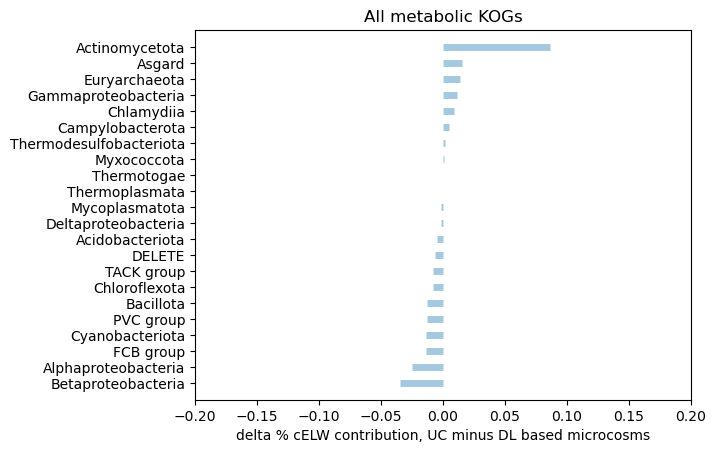

In [27]:
cELW_delta_df = (cELW_freq - cELW_dl_freq).reset_index()
cELW_delta_df = cELW_delta_df.sort_index(ascending = False).fillna(0)
plt.figure()
plt.hlines(y=cELW_delta_df.sort_values(0).prok_taxa, xmin=0, xmax=cELW_delta_df[0].sort_values(), 
           alpha=0.4, linewidth=5) 
plt.xlim(-.2,.2)
plt.xlabel("delta % cELW contribution, UC minus DL based microcosms")
plt.title(f"All metabolic KOGs")

In [16]:
kogs = set(kog_brite[(kog_brite.brite_B.isin(list(brite2desc.keys())))].kogid)
trees_dl_filtered = tree_data_dl_mapped[tree_data_dl_mapped.KOGS.isin(kogs)]
trees_dl_tophit = trees_dl_filtered.sort_values(["c-ELW"], ascending = False).drop_duplicates("euk_clade_rep").sort_values(["tree_name"])
trees_dl_cELW_breakdown = trees_dl_filtered[trees_dl_filtered["c-ELW"].between(.5,1) & (trees_dl_filtered.logL != -1)]
cELW_dl_freq = trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum() / sum(trees_dl_cELW_breakdown.groupby("prok_taxa")["c-ELW"].sum())
cELW_dl_freq


prok_taxa
Acidobacteriota            0.009276
Actinomycetota             0.136897
Alphaproteobacteria        0.159755
Asgard                     0.027351
Bacillota                  0.086656
Betaproteobacteria         0.078562
Campylobacterota           0.008247
Chlamydiia                 0.006259
Chloroflexota              0.010480
Cyanobacteriota            0.106186
DELETE                     0.020915
Deltaproteobacteria        0.002118
Euryarchaeota              0.015643
FCB group                  0.097789
Gammaproteobacteria        0.115173
Mycoplasmatota             0.006810
Myxococcota                0.023891
PVC group                  0.054054
TACK group                 0.019868
Thermodesulfobacteriota    0.014070
Name: c-ELW, dtype: float64

/tmp/ipykernel_3491552/1812269985.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cELW_df = pd.DataFrame(cELW_breakdowns).fillna(0)


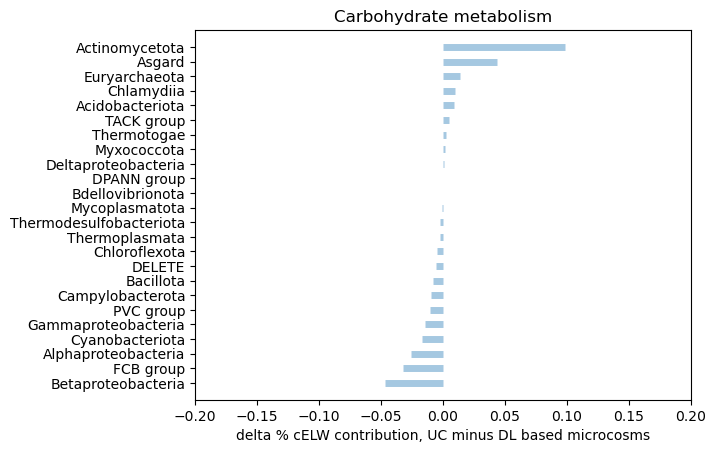

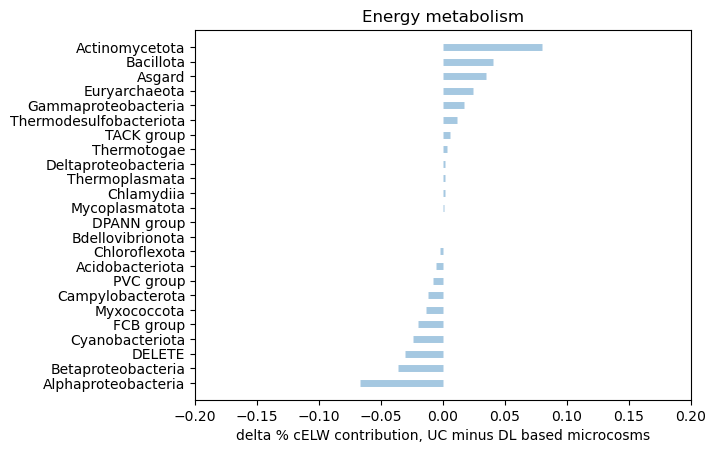

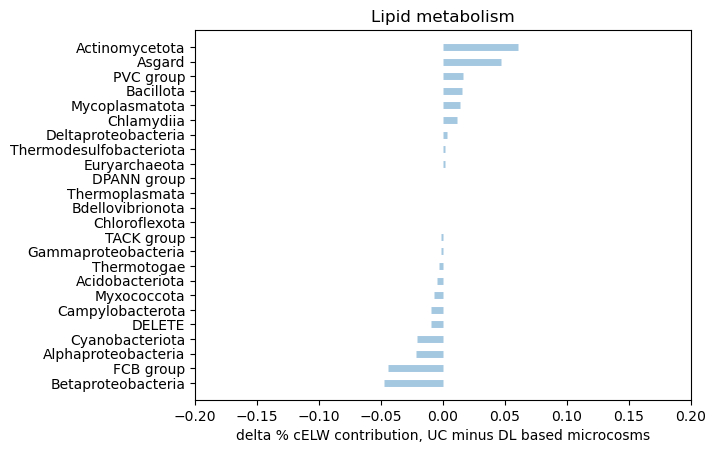

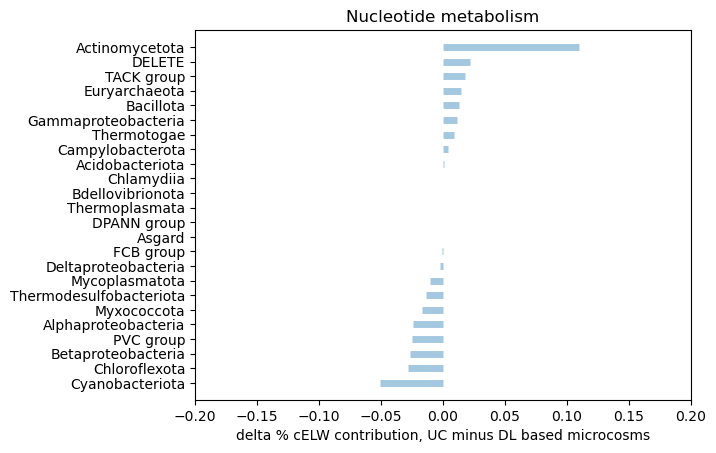

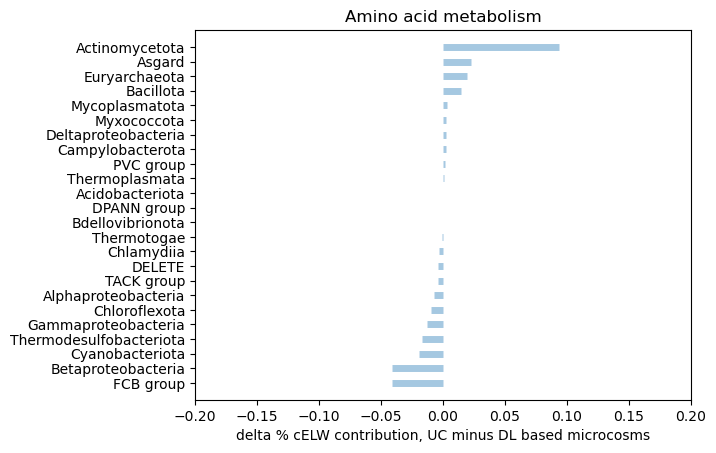

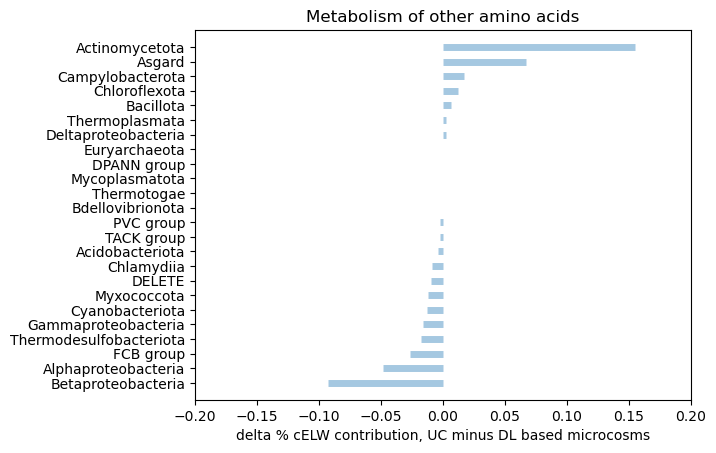

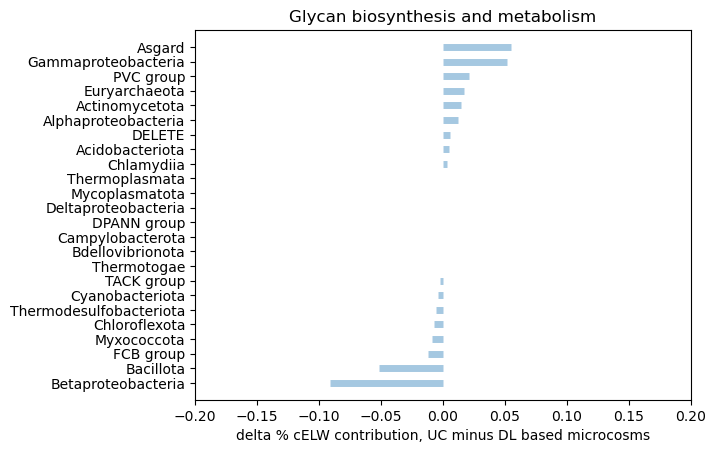

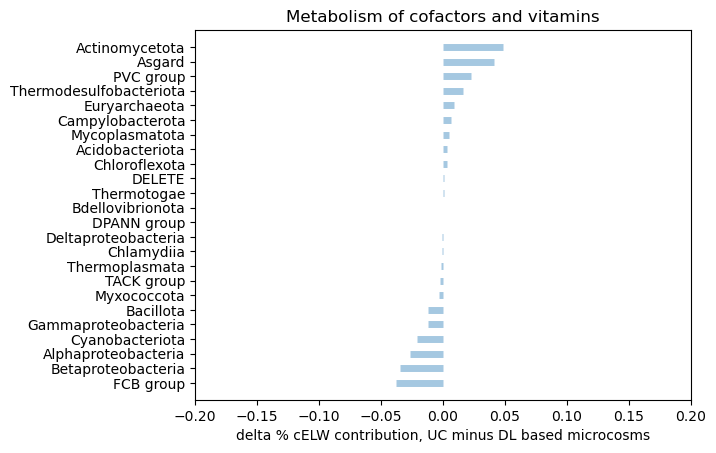

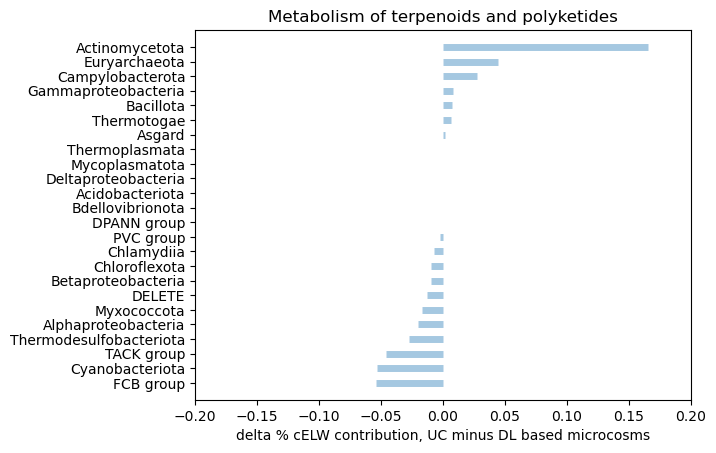

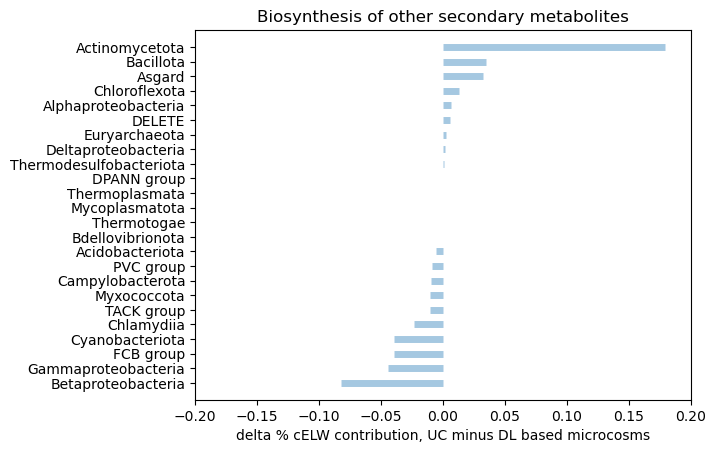

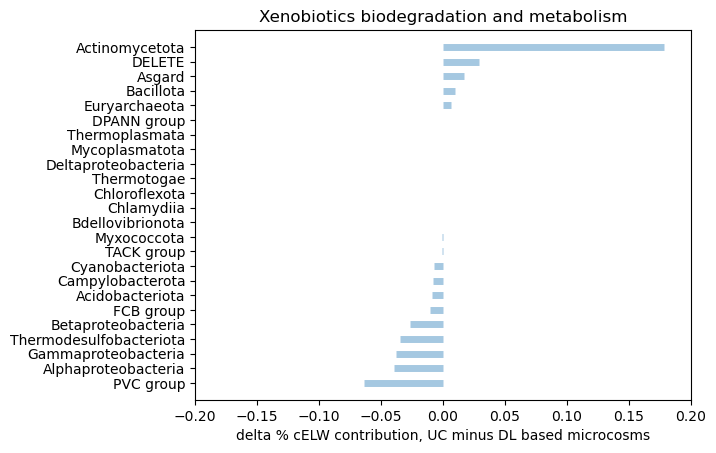

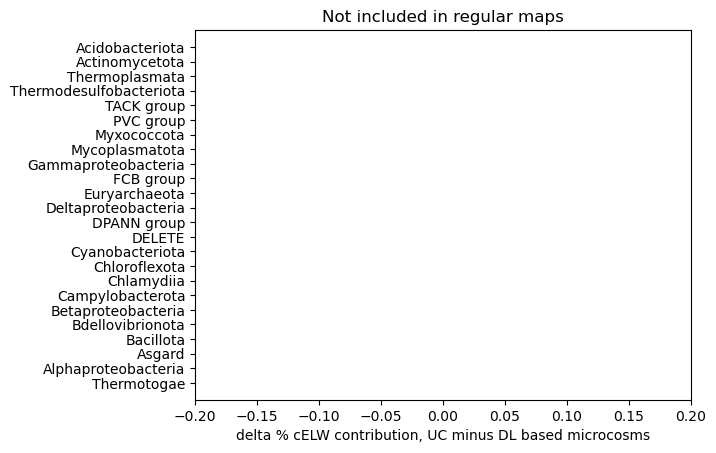

In [10]:
cELW_df = pd.DataFrame(cELW_breakdowns).fillna(0)
cELW_dl_df = pd.DataFrame(cELW_dl_breakdowns).fillna(0)
cELW_delta_df = cELW_df - cELW_dl_df
cELW_delta_df = cELW_delta_df.sort_index(ascending = False).fillna(0)
for colname in cELW_delta_df.columns:
    plt.figure()
    plt.hlines(y=cELW_delta_df.sort_values(colname).index, xmin=0, xmax=cELW_delta_df[colname].sort_values(), 
               alpha=0.4, linewidth=5) 
    plt.xlim(-.2,.2)
    plt.xlabel("delta % cELW contribution, UC minus DL based microcosms")
    plt.title(f"{colname}")

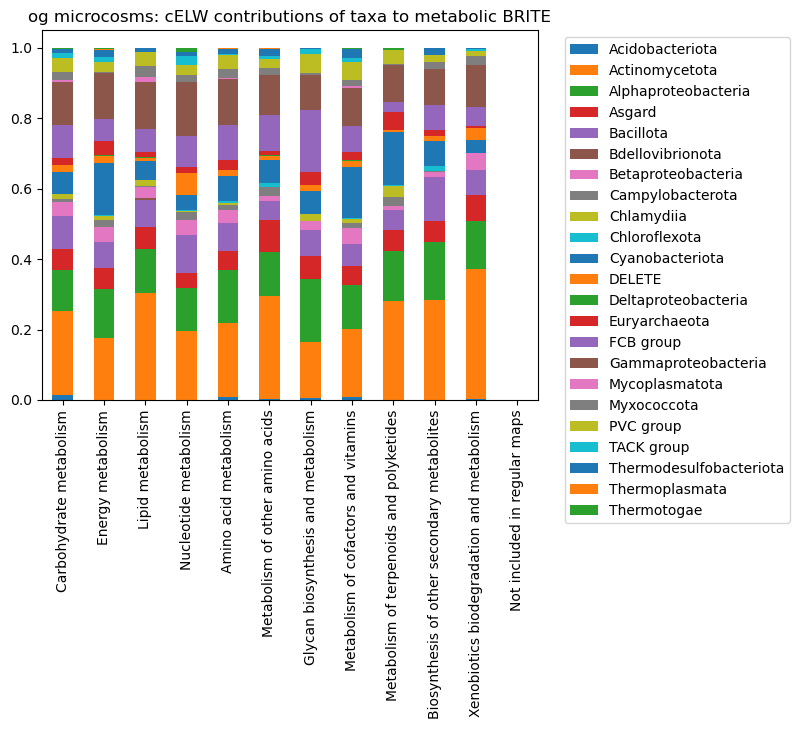

In [11]:
cELW_df.T.plot(kind='bar', stacked=True,
        title='og microcosms: cELW contributions of taxa to metabolic BRITE')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

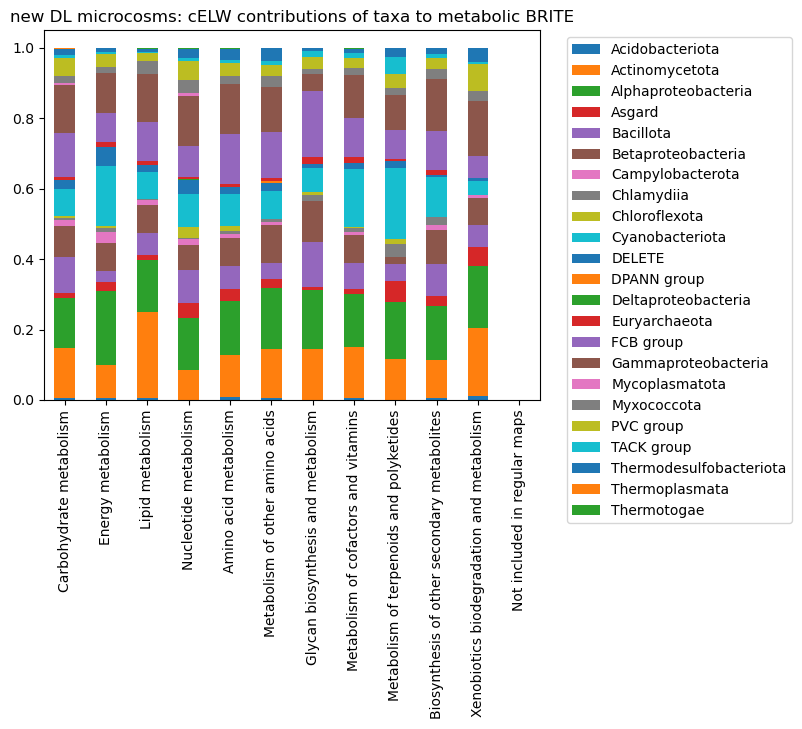

In [12]:
cELW_dl_df = pd.DataFrame(cELW_dl_breakdowns).fillna(0)
cELW_dl_df.T.plot(kind='bar', stacked=True,
        title='new DL microcosms: cELW contributions of taxa to metabolic BRITE')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [10]:
trees_cELW = pd.read_csv("/data/luojaa/eukgen/microcosm/trees_cELW_sankey.updated.tsv", sep = "\t")
trees_dl_cELW = pd.read_csv("/data/luojaa/eukgen/microcosm/trees_dl_cELW_sankey.updated.tsv", sep = "\t")

In [11]:
# map the new taxa onto the old microcosm df
old2new_taxa = trees_dl_cELW.groupby("tree_name")["prok_taxa"].agg(lambda x: ",".join(set(x))).to_dict()
def map_old2new(ec_kog):
    try:
        return old2new_taxa[ec_kog]
    except KeyError:
        try:
            ec_kog = ec_kog.split("_")[0] + "_None"
            return old2new_taxa[ec_kog]
        except KeyError:
            return "None"
        
trees_cELW["prok_taxa_new"] = trees_cELW.EC_KOG.apply(lambda x: map_old2new(x))

In [12]:
sum(trees_cELW.EC.isin(set(trees_dl_cELW.EC)))

4175

In [13]:
def reweighted_cELWs(df_uc):
    g = df_uc.groupby("prok_taxa_new")["cELW_norm"].sum().reset_index()
    g["weight"] = g.iloc[:,0].apply(lambda x: 1 / len(x.split(",")))
    # each microcosm contributes to 1 "taxa weight"
    g["cELW_weighted"] = g["cELW_norm"] * g["weight"]
    g["taxa"] = g.iloc[:,0].apply(lambda x: x.split(","))
    h = g.explode("taxa")
    reweighted = h.groupby("taxa")["cELW_weighted"].sum().round().sort_values(ascending = False)
    return reweighted[reweighted.index != "None"]
def reweighted_vc(s):
    g = s.value_counts().reset_index()
    g["weight"] = g.iloc[:,0].apply(lambda x: 1 / len(x.split(",")))
    # each microcosm contributes to 1 "taxa weight"
    g["count_weighted"] = g["count"] * g["weight"]
    g["taxa"] = g.iloc[:,0].apply(lambda x: x.split(","))
    h = g.explode("taxa")
    reweighted_vc = h.groupby("taxa")["count_weighted"].sum().round().sort_values(ascending = False)
    return reweighted_vc#[reweighted_vc.index != "None"]

In [14]:
len(trees_cELW.tree_name.unique()), len(trees_cELW.euk_clade_rep.unique())

(5509, 7170)

In [15]:
len(trees_cELW.tree_name.unique()), len(trees_cELW.euk_clade_rep.unique())

(5509, 7170)

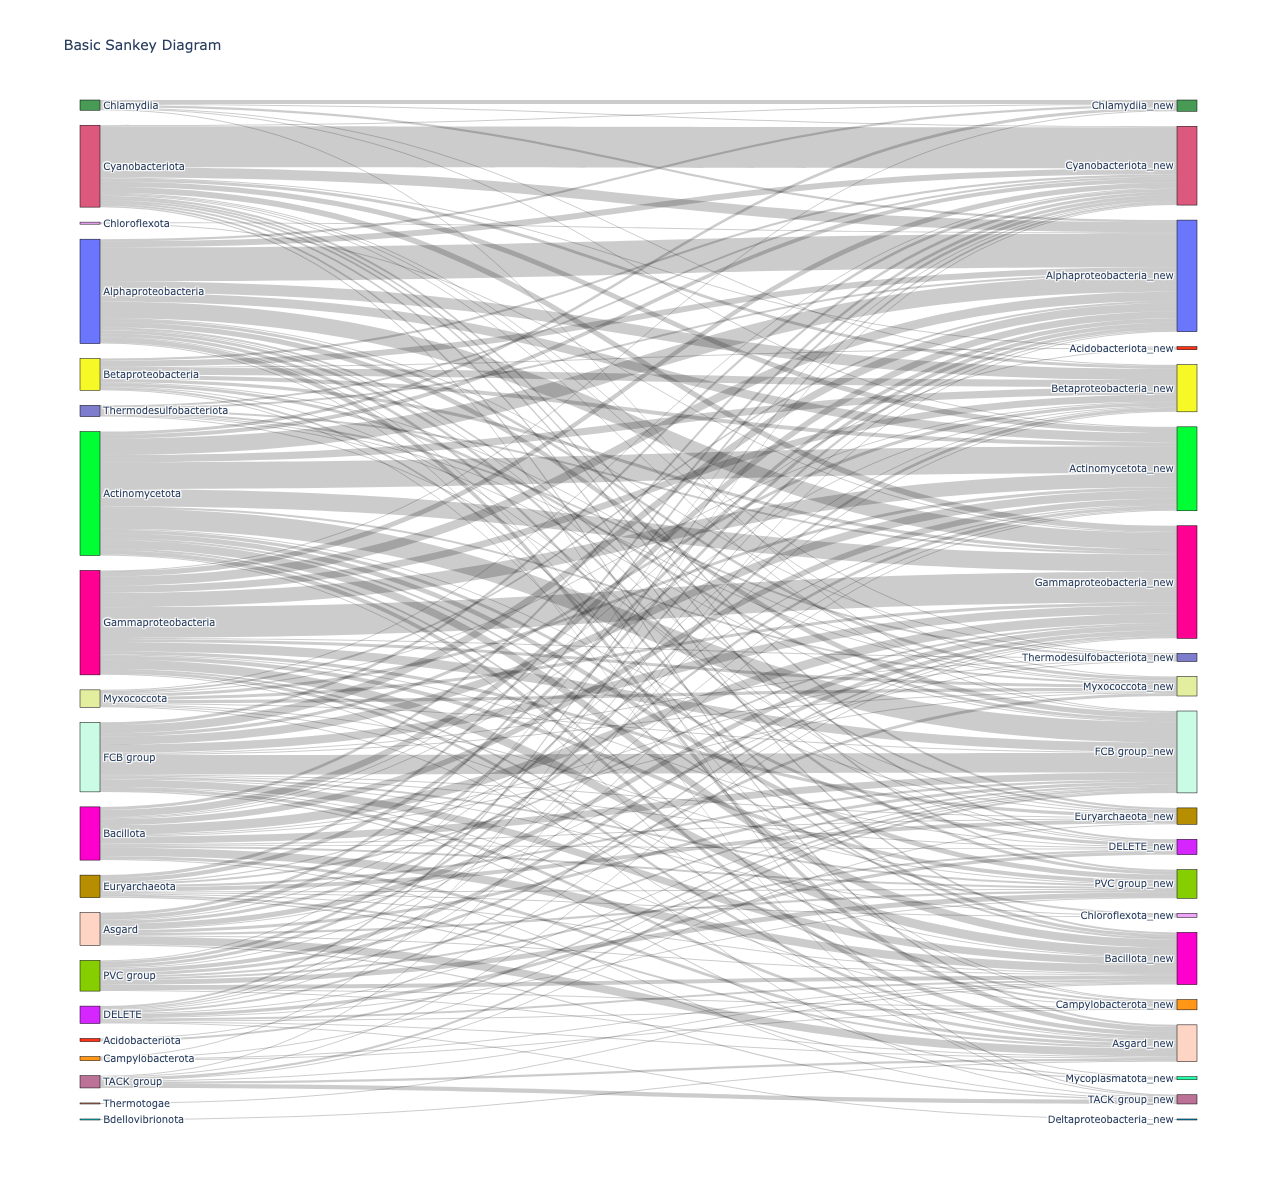

In [20]:
trees_cELW_plot = trees_cELW
trees_cELW_plot = trees_cELW_plot[trees_cELW_plot["c-ELW"] > .52]
trees_cELW_dl_plot = trees_dl_cELW
trees_cELW_dl_plot = trees_cELW_dl_plot[trees_cELW_dl_plot["c-ELW"] > .52]
label = list(pd.concat([trees_cELW_dl_plot.prok_taxa, trees_cELW.prok_taxa]).sort_values().unique())
label_all = label + [i + "_new" for i in label] + ["None"]
cELWs = [reweighted_cELWs(trees_cELW_plot[trees_cELW_plot.prok_taxa == taxa]) for taxa in label]
label_map = {v:k for k, v in dict(enumerate(label + ["None"])).items()}
source, target, value, j = [], [], [], 0
for i in cELWs:
    target += [label_map[taxa] + 24 for taxa in list(i.index)]
    value += list(i)
    source += [j]*len(i)
    j += 1
    
fig1 = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label_all,
      color = px.colors.qualitative.Light24 * 2
    ),
    link = dict(
      source = source, # indices correspond to labels
      target = target,
      value = value
  ))])

fig1.update_layout(title_text="Basic Sankey Diagram", font_size=10, autosize=False, width=800, height=1200)
fig1.show()


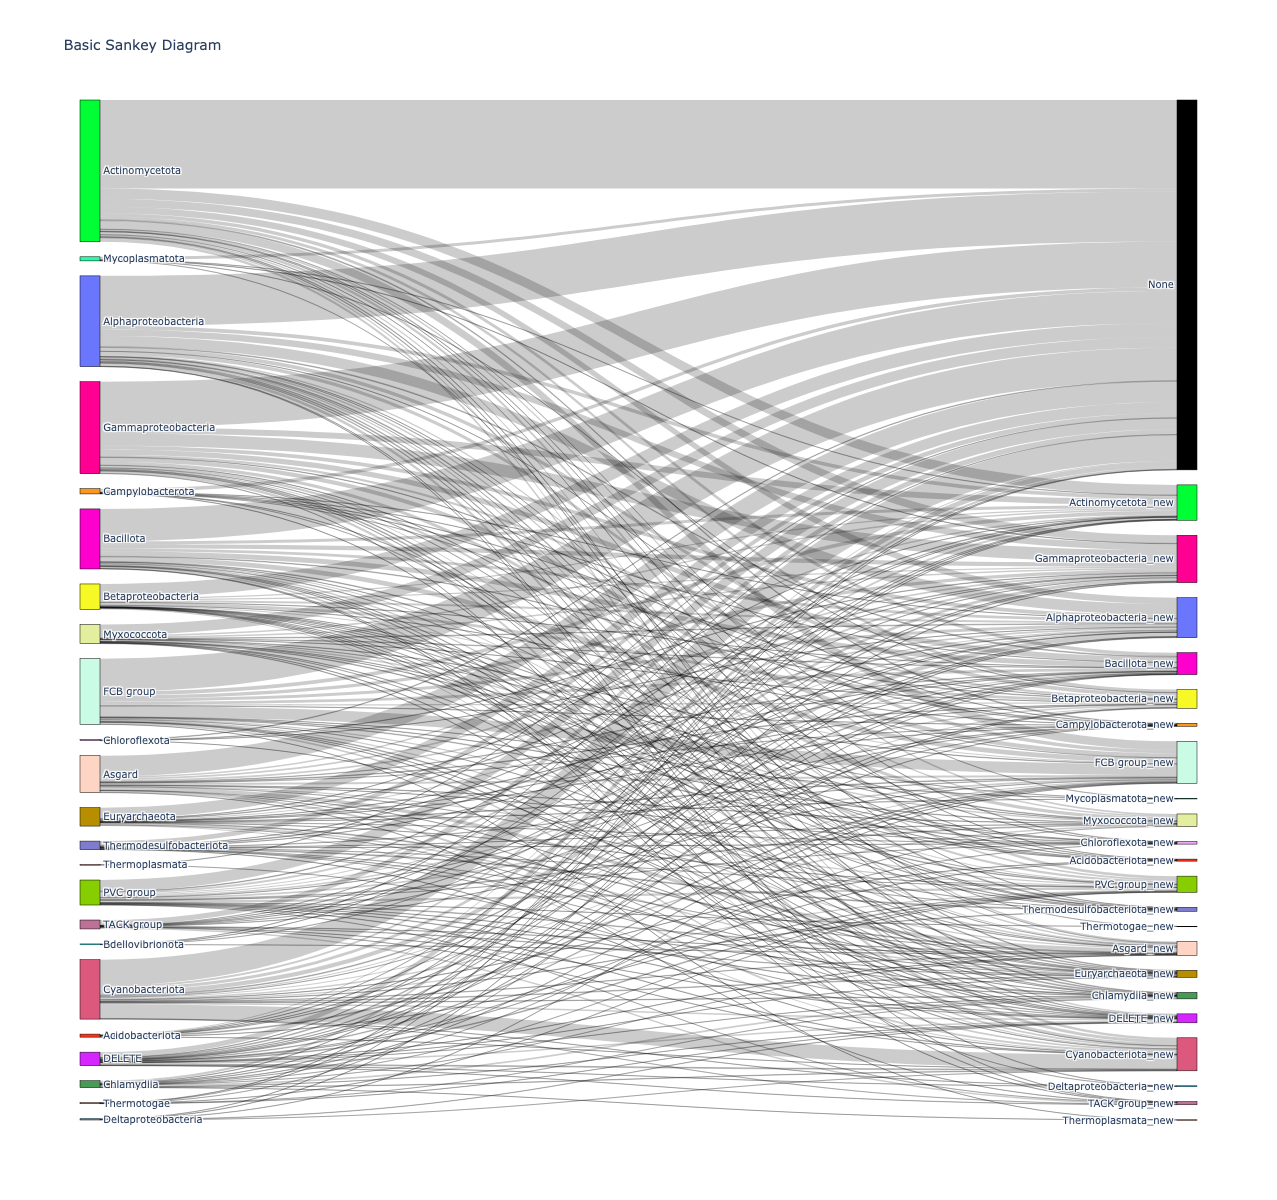

In [21]:
trees_cELW_plot = trees_cELW
trees_cELW_plot = trees_cELW_plot[trees_cELW_plot["c-ELW"] > .52]
label = list(pd.concat([trees_dl_cELW.prok_taxa, trees_cELW.prok_taxa]).sort_values().unique())
label_all = label + [i + "_new" for i in label] + ["None"]
vcs = [reweighted_vc(trees_cELW_plot[trees_cELW_plot.prok_taxa == taxa].prok_taxa_new) for taxa in label]
label_map = {v:k for k, v in dict(enumerate(label + ["None"])).items()}
source, target, value, j = [], [], [], 0
for i in vcs:
    target += [label_map[taxa] + 24 for taxa in list(i.index)]
    value += list(i)
    source += [j]*len(i)
    j += 1
    
fig2 = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label_all,
      color = px.colors.qualitative.Light24 * 2
    ),
    link = dict(
      source = source, # indices correspond to labels
      target = target,
      value = value
  ))])

fig2.update_layout(title_text="Basic Sankey Diagram", font_size=10, autosize=False, width=800, height=1200)
fig2.show()


In [24]:
# reverse mapping, old onto new
new2old_taxa = trees_cELW.groupby("EC_KOG")["prok_taxa"].agg(lambda x: ",".join(set(x))).to_dict()
new_tids = set(trees_dl_cELW.tree_name)
new_none2old_taxa = {}
for old_taxa in new2old_taxa.keys():
    if old_taxa not in new_tids:
        ec_none = old_taxa.split("_")[0] + "_None"
        new_none2old_taxa[ec_none] = new2old_taxa[old_taxa]
def map_new2old(ec_kog):
    try:
        return new2old_taxa[ec_kog]
    except KeyError:
        try:
            return new_none2old_taxa[ec_kog]
        except KeyError:
            return "None"
trees_dl_cELW["prok_taxa_old"] = trees_dl_cELW.tree_name.apply(lambda x: map_new2old(x))

In [66]:
trees_cELW_dl_frac = trees_dl_cELW.groupby(["prok_taxa", "EC"])["c-ELW"].sum().reset_index()
celw_dl_frac, groupsize = [], []
for i in range(len(trees_cELW_dl_frac)):
    ec = trees_cELW_dl_frac.iloc[i, 1]
    taxa = trees_cELW_dl_frac.iloc[i, 0]
    trees_cELW_dl_ecfilt = trees_cELW_dl_frac[trees_cELW_dl_frac.EC == ec]
    frac = trees_cELW_dl_ecfilt[trees_cELW_dl_ecfilt.prok_taxa == taxa].iloc[0,2] / sum(trees_cELW_dl_ecfilt["c-ELW"])
    celw_dl_frac += [frac]
    groupsize += [len(trees_cELW_dl_ecfilt)]
trees_cELW_dl_frac["cELW_frac"] = celw_dl_frac
trees_cELW_dl_frac["groupsize"] = groupsize


In [127]:
taxa = "Cyanobacteriota"
trees_cELW_dl_frac_filt = trees_cELW_dl_frac[trees_cELW_dl_frac.prok_taxa == taxa].sort_values(["cELW_frac", "c-ELW"], ascending = False)
f = pd.merge(trees_cELW_dl_frac_filt, ec_2kog.rename(columns={"EC_single":"EC"}).drop_duplicates("EC"), on = "EC", how = "left").drop(["prok_taxa", "c-ELW", "kogid"], axis = 1)
g = pd.merge(trees_dl_cELW, f, how = "inner", on = "EC").fillna("None")
g["KOGID"] = g.tree_name.apply(lambda x: x.split("_")[1])
#h = pd.merge(g, module_data, how = "left", on = "KOGID")
h = g[~g.prok_taxa_old.str.contains(taxa)].sort_values("cELW_frac")
i = h[h["c-ELW"] > .7]
j = i[i.cELW_frac > .3]

len(j), len(i), len(h), len(g)

(92, 167, 365, 523)

In [126]:
taxa = "Alphaproteobacteria"
trees_cELW_dl_frac_filt = trees_cELW_dl_frac[trees_cELW_dl_frac.prok_taxa == taxa].sort_values(["cELW_frac", "c-ELW"], ascending = False)
f = pd.merge(trees_cELW_dl_frac_filt, ec_2kog.rename(columns={"EC_single":"EC"}).drop_duplicates("EC"), on = "EC", how = "left").drop(["prok_taxa", "c-ELW", "kogid"], axis = 1)
g = pd.merge(trees_dl_cELW, f, how = "inner", on = "EC").fillna("None")
g["KOGID"] = g.tree_name.apply(lambda x: x.split("_")[1])
#h = pd.merge(g, module_data, how = "left", on = "KOGID")
h = g[~g.prok_taxa_old.str.contains(taxa)].sort_values("cELW_frac")
i = h[h["c-ELW"] > .7]
j = i[i.cELW_frac > .3]

len(j), len(i), len(h), len(g)

(164, 267, 516, 664)

In [128]:
list(g[(g["c-ELW"] > .7) & (g["cELW_frac"] > .3)].name.unique())

['psbA; photosystem II P680 reaction center D1 protein [EC:1.10.3.9]',
 'VBPO; bromide peroxidase [EC:1.11.1.18]',
 'PRDX6; peroxiredoxin 6 [EC:1.11.1.7 1.11.1.27 3.1.1.-]',
 'ribD2; 5-amino-6-(5-phosphoribosylamino)uracil reductase [EC:1.1.1.193]',
 'dxr; 1-deoxy-D-xylulose-5-phosphate reductoisomerase [EC:1.1.1.267]',
 'E1.1.1.65; pyridoxine 4-dehydrogenase [EC:1.1.1.65]',
 'LOX1_5; linoleate 9S-lipoxygenase [EC:1.13.11.58]',
 'HAO; (S)-2-hydroxy-acid oxidase [EC:1.1.3.15]',
 'HMOX1; heme oxygenase 1 [EC:1.14.14.18]',
 'CP; ceruloplasmin [EC:1.16.3.1]',
 'ispH, lytB; 4-hydroxy-3-methylbut-2-en-1-yl diphosphate reductase [EC:1.17.7.4]',
 'petH; ferredoxin--NADP+ reductase [EC:1.18.1.2]',
 'proA; glutamate-5-semialdehyde dehydrogenase [EC:1.2.1.41]',
 'hemA; glutamyl-tRNA reductase [EC:1.2.1.70]',
 'por; protochlorophyllide reductase [EC:1.3.1.33]',
 'chlP, bchP; geranylgeranyl diphosphate/geranylgeranyl-bacteriochlorophyllide a reductase [EC:1.3.1.83 1.3.1.111]',
 'chlL; light-indepen

In [76]:
len(g)

664

In [ ]:
brite

In [19]:
def reweighted_cELWs_dl(df_uc):
    g = df_uc.groupby("prok_taxa_old")["c-ELW"].sum().reset_index()
    g["weight"] = g.iloc[:,0].apply(lambda x: 1 / len(x.split(",")))
    # each microcosm contributes to 1 "taxa weight"
    g["cELW_weighted"] = g["c-ELW"] * g["weight"]
    g["taxa"] = g.iloc[:,0].apply(lambda x: x.split(","))
    h = g.explode("taxa")
    reweighted = h.groupby("taxa")["cELW_weighted"].sum().round().sort_values(ascending = False)
    return reweighted#[reweighted.index != "None"]
# def reweighted_vc(s):
#     g = s.value_counts().reset_index()
#     g["weight"] = g.iloc[:,0].apply(lambda x: 1 / len(x.split(",")))
#     # each microcosm contributes to 1 "taxa weight"
#     g["count_weighted"] = g["count"] * g["weight"]
#     g["taxa"] = g.iloc[:,0].apply(lambda x: x.split(","))
#     h = g.explode("taxa")
#     reweighted_vc = h.groupby("taxa")["count_weighted"].sum().round().sort_values(ascending = False)
#     return reweighted_vc#[reweighted_vc.index != "None"]

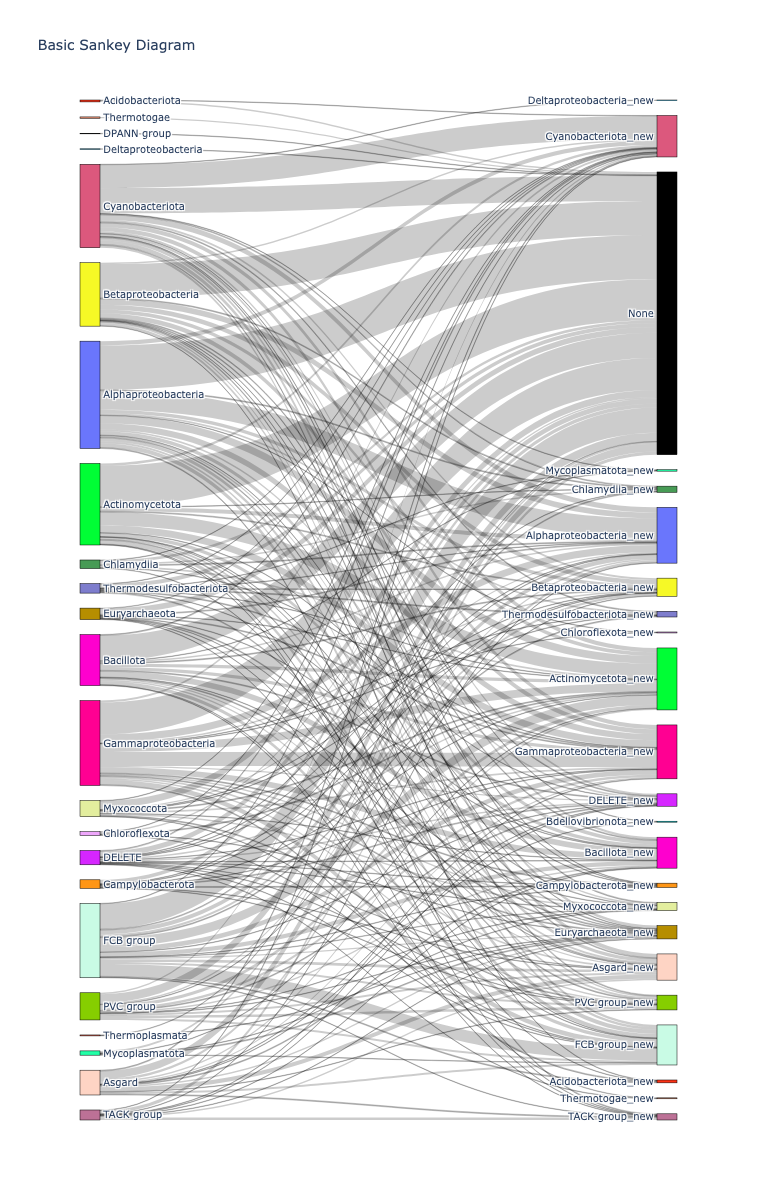

In [188]:
trees_cELW_dl_plot = trees_dl_cELW
trees_cELW_dl_plot = trees_cELW_dl_plot[trees_cELW_dl_plot["c-ELW"] > .52]
label = list(pd.concat([trees_cELW_dl_plot.prok_taxa, trees_cELW.prok_taxa]).sort_values().unique())
label_all = label + [i + "_new" for i in label] + ["None"]
cELWs = [reweighted_cELWs_dl(trees_cELW_dl_plot[trees_cELW_dl_plot.prok_taxa == taxa]) for taxa in label]
label_map = {v:k for k, v in dict(enumerate(label + ["None"])).items()}
source, target, value, j = [], [], [], 0
for i in cELWs:
    target += [label_map[taxa] + 24 for taxa in list(i.index)]
    value += list(i)
    source += [j]*len(i)
    j += 1
    
fig3 = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = label_all,
      color = px.colors.qualitative.Light24 * 2
    ),
    link = dict(
      source = source, # indices correspond to labels
      target = target,
      value = value
  ))])

fig3.update_layout(title_text="Basic Sankey Diagram", font_size=10, autosize=False, width=800, height=1200)
fig3.show()


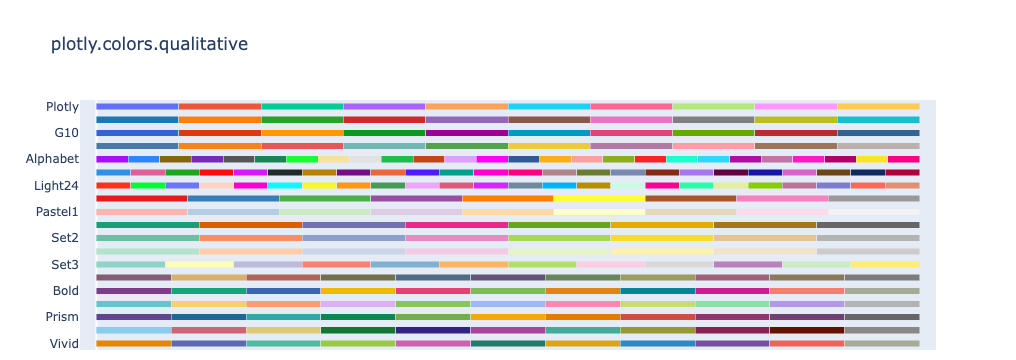

In [268]:
fig = px.colors.qualitative.swatches()
fig.show()